# Actor-Critic (Temporal Difference): Bootstrapping for Sample Efficiency

## 🎯 The Leap from Monte Carlo to Temporal Difference

Welcome to **Actor-Critic Temporal Difference (TD)** - where we make the crucial transition from using complete episode returns to **bootstrapping** with learned value estimates. This represents a fundamental shift in how we learn from experience.

**The Core Innovation**: Instead of waiting for complete episodes, we can update our networks every **N steps** using the **Bellman Expectation Equation** to estimate future returns.

## 🧠 A Quick Note on Foundations: Dynamic Programming in RL

Behind both Monte Carlo and Temporal Difference methods lies the classic theory of **Dynamic Programming (DP)**. DP gives us two foundational algorithms:

- **Policy Iteration**: Alternates between evaluating a policy and improving it
- **Value Iteration**: Directly updates value estimates using greedy improvement

These ideas assume full knowledge of the environment (i.e., transition probabilities), which we rarely have in practice. In deep RL, we approximate these updates from samples.

In this notebook, we focus on **on-policy TD methods**, which approximate **policy iteration** by:
- Evaluating the current policy with TD
- Improving it using policy gradients (Actor-Critic)

If you're curious about how **value iteration** leads to **off-policy methods** like DQN, check out the [off-policy-rl repository](https://github.com/tae898/off-policy-rl) where we explore those ideas in depth.

## 📐 The Bellman Expectation Equation: Foundation of TD Learning

### Understanding the Two Bellman Equations

There are **two different Bellman equations** in reinforcement learning, each serving different purposes:

#### 1. Bellman Optimality Equation (Off-Policy Learning)
$$V^*(s) = \max_a \mathbb{E}[r + \gamma V^*(s')]$$

- **Purpose**: Defines the optimal value function
- **Used in**: off-policy methods
- **Characteristic**: Uses **max** operator over actions
- **Target**: Find the best possible policy

#### 2. Bellman Expectation Equation (On-Policy Learning)
$$V^\pi(s) = \mathbb{E}_{\pi}[r + \gamma V^\pi(s')]$$

- **Purpose**: Defines value function for a specific policy $\pi$
- **Used in**: on-policy learning
- **Characteristic**: Uses **expectation** under current policy
- **Target**: Evaluate and improve current policy

### Why We Use Bellman Expectation in Actor-Critic

**Key Insight**: Since we're learning both a policy (actor) and its value function (critic) simultaneously, we need the **expectation equation** that evaluates our **current policy**, not the optimal policy.

**Mathematical Foundation**:
$$V^\pi(s_t) = \mathbb{E}_{\pi}[r_{t+1} + \gamma V^\pi(s_{t+1})]$$

**Expanded Form**:
$$V^\pi(s_t) = \sum_{a_{t}} \pi(a_t|s_t) \sum_{s_{t+1}} P(s_{t+1}|s_t, a_t) [r(s_t, a_t) + \gamma V^\pi(s_{t+1})]$$

**Practical Implementation**: Since we don't know the environment dynamics $P(s_{t+1}|s_t, a_t)$, we use **sample-based estimates**:

$$V^\pi(s_t) \approx r_{t+1} + \gamma V^\pi(s_{t+1})$$

This gives us the **TD target**: $y_t = r_{t+1} + \gamma V(s_{t+1})$

## 🔄 Bootstrapping: The Game Changer

**Bootstrapping** means using our own estimates to update our estimates. Instead of waiting for actual returns $G_t$, we use:

$$\text{TD Target} = r_{t+1} + \gamma V_\phi(s_{t+1})$$

### Monte Carlo vs Temporal Difference Comparison

**Monte Carlo (Previous Notebook)**:
- **Trajectory**: $s_0 \xrightarrow{a_0} s_1 \xrightarrow{a_1} s_2 \xrightarrow{a_2} \ldots \xrightarrow{a_{T-1}} s_T$ (terminal)
- **Target**: $G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \ldots + \gamma^{T-t-1} r_T$
- **Update**: After complete episode ($T$ steps)

**Temporal Difference (This Notebook)**:
- **N-Step Sequence**: $s_t \xrightarrow{a_t} s_{t+1} \xrightarrow{a_{t+1}} s_{t+2} \xrightarrow{a_{t+2}} \ldots \xrightarrow{a_{t+N-1}} s_{t+N}$
- **Target**: $G_t^{(N)} = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{N-1} r_{t+N} + \gamma^N V_\phi(s_{t+N})$
- **Update**: Every $N$ steps (where $N \ll T$ typically)

### Advantages of Bootstrapping

1. **Sample Efficiency**: Learn from incomplete episodes
2. **Online Learning**: Update during episode, not just at the end
3. **Lower Variance**: Bootstrapped estimates typically have lower variance than MC
4. **Faster Learning**: More frequent updates accelerate convergence

### The Bias-Variance Tradeoff

**Monte Carlo**: 
- ✅ **Unbiased**: $\mathbb{E}[G_t] = V^\pi(s_t)$ exactly
- ❌ **High Variance**: Episode returns vary dramatically

**Temporal Difference**:
- ❌ **Biased**: $\mathbb{E}[r + \gamma V(s')] \neq V^\pi(s)$ if $V$ is inaccurate
- ✅ **Lower Variance**: Single-step rewards plus learned estimates

**The Key Insight**: Early in training, our value estimates $V_\phi(s_{t+1})$ are wrong, introducing bias. But as training progresses, $V_\phi$ becomes more accurate, and the bias decreases while maintaining low variance.

## 🔢 N-Step Updates: Configurable Bootstrapping

**N-Step TD** provides a spectrum between Monte Carlo and 1-step TD:

### N-Step Target Calculation

For N-step updates, our target becomes:
$$G_t^{(N)} = \sum_{k=0}^{N-1} \gamma^k r_{t+k+1} + \gamma^N V_\phi(s_{t+N})$$

**Special Cases**:
- **N=1**: Pure TD learning $G_t^{(1)} = r_{t+1} + \gamma V(s_{t+1})$
- **N=T** (episode length): Pure Monte Carlo $G_t^{(T)} = G_t$ (actual return)
- **N=5**: Balanced approach (common choice)

### Update Frequency Implications

This creates an important difference in learning dynamics compared to Monte Carlo methods:

**Monte Carlo Methods**:
- **Update Frequency**: Low
- **Learning Speed**: Slower but stable

- **Network Updates**: ~100,000+ updates (multiple per episode)
- **Update Frequency**: High
- **Learning Speed**: Faster but potentially less stable

**⚠️ Comparison Challenge**: Direct comparison between MC and TD methods is complex because:
- Different update frequencies
- Different learning dynamics
- Different bias-variance profiles
- Different data utilization patterns

## 🎯 Normalization Strategy in TD Methods

### The Key Difference: Why No Critic Loss Normalization

**In Actor-Critic MC** (Previous Notebook):
```python
# We normalized returns for critic learning
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
critic_loss = mse_loss(value_predictions, returns_normalized)
```

**In Actor-Critic TD** (This Notebook):
```python
# NO normalization of TD targets for critic learning
td_targets = rewards + gamma * next_values
critic_loss = mse_loss(value_predictions, td_targets)  # No normalization!
```

### Why This Difference Matters

**Monte Carlo Targets** (High Variance):
- **Nature**: Raw episode returns $G_t$ with extreme variance
- **Range**: LunarLander returns span [-200, +300]
- **Problem**: Poor scaling for neural network training
- **Solution**: Normalization helps stabilize learning

**TD Targets** (Lower Variance):
- **Nature**: Bootstrapped estimates $r + \gamma V(s')$
- **Range**: Single rewards plus learned estimates (more controlled)
- **Stability**: Naturally more stable than raw episode returns
- **Risk**: Normalization would break the value function's meaning

### Why Normalization Breaks TD Learning

**The Recursive Relationship Problem**:
$$V(s_t) = r_{t+1} + \gamma V(s_{t+1}) \quad \text{(This relationship must hold!)}$$

**If we normalize targets**:
$$V(s_t) = \text{normalize}(r_{t+1} + \gamma V(s_{t+1})) \quad \text{(Breaks recursion!)}$$

**Bootstrapping Requirement**: Since we use $V(s_{t+1})$ to train $V(s_t)$, the value function must maintain consistent scale across all states and timesteps.

### Advantage Normalization: Still Essential

While we don't normalize critic targets, we **absolutely still normalize advantages**:

```python
# Calculate advantages using TD targets
advantages = td_targets - value_predictions.detach()

# Normalize advantages for stable actor updates
advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

# Actor loss uses normalized advantages
actor_loss = -(log_probs * advantages_normalized).mean()
```

**Why Advantage Normalization Remains Important**:
- **Stable Policy Updates**: Prevents destructively large gradient steps
- **Consistent Learning Rate**: Maintains effective learning rate across different update batches
- **Preserved Relative Importance**: Actions that are relatively better still get stronger signals

**⚠️ TD-Specific Challenge**: Advantage normalization in TD methods is more prone to NaN issues due to smaller sample sizes (N-steps vs full episodes). With fewer samples, the computed standard deviation can be very small, leading to potential division by zero or near-zero during normalization. Care must be taken to ensure numerical stability in these cases. That's why in our implementation, if we run into a NaN issue, we'll only center the advantages, but not scale them.

## ⚡ Gradient Norm Clipping: Essential for TD Stability

### Why TD Methods Need Gradient Clipping

**The Instability Challenge**: TD-based Actor-Critic methods face unique stability challenges that make gradient clipping essential:

#### 1. Bootstrapping Feedback Loop
$$\text{Current Value Estimate} \rightarrow \text{TD Target} \rightarrow \text{Critic Update} \rightarrow \text{New Value Estimate} \rightarrow \ldots$$
- **Self-Referential Learning**: Network learns from its own predictions
- **Error Amplification**: Mistakes in value estimates compound over time
- **Feedback Instability**: Poor estimates create poor targets, leading to worse estimates

#### 2. High Variance from Multiple Sources
- **Bootstrapped Targets**: $r + \gamma V(s')$ depends on potentially inaccurate $V(s')$
- **Correlated Samples**: Sequential states in episodes are highly correlated
- **On-Policy Distribution**: Data distribution constantly shifts as policy improves
- **Policy-Value Coupling**: Actor and critic updates affect each other

#### 3. Early Training Chaos
- **Random Initialization**: Value estimates start completely wrong
- **Exploration Noise**: Policy exploration creates additional variance
- **Learning Competition**: Actor and critic learning can interfere with each other

### Gradient Clipping Implementation

**Max Gradient Norm Clipping**:
```python
# Clip gradients to prevent explosive updates
torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_grad_norm)
```

**How It Works**:
1. **Calculate Total Gradient Norm**: $\|g\| = \sqrt{\sum_i \|g_i\|^2}$
2. **Check Threshold**: If $\|g\| > \text{max\_grad\_norm}$
3. **Scale Down**: $g_{clipped} = g \cdot \frac{\text{max\_grad\_norm}}{\|g\|}$
4. **Preserve Direction**: Gradient direction unchanged, only magnitude reduced

### Benefits of Gradient Clipping

1. **Prevents Explosion**: Stops catastrophically large updates that destroy learning progress
2. **Stabilizes Training**: Reduces variance in parameter updates
3. **Enables Higher Learning Rates**: Can use more aggressive learning rates safely
4. **Improves Convergence**: More stable path to optimal solution
5. **Robustness**: Makes training less sensitive to hyperparameter choices

### Implementation Note: Display Original Gradient Norms

**Important**: In our training progress bar, we display the **original (unclipped) gradient norm** for monitoring purposes:

```python
# Calculate and store original gradient norm BEFORE clipping
original_grad_norm = calculate_gradient_norm(network.parameters())

# Apply gradient clipping
torch.nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)

# Display original norm in progress bar (not the clipped value)
progress_bar.set_description(f"GradNorm: {original_grad_norm:.4f}")
```

**Why Display Original Norms**:
- **Training Diagnostics**: Monitor if gradients are frequently being clipped
- **Hyperparameter Tuning**: Adjust `max_grad_norm` based on typical gradient magnitudes
- **Stability Assessment**: Track training stability over time
- **Debug Information**: Identify potential training issues

## 🏗️ Actor-Critic TD Architecture

The network architecture remains the same as Actor-Critic MC, but the learning algorithm changes fundamentally:

### Network Components (Unchanged)
- **Shared Features**: Common representation learning for both actor and critic
- **Actor Head**: Policy distribution output (discrete or continuous)
- **Critic Head**: Single value estimate output

### Learning Algorithm (Revolutionized)
- **Update Frequency**: Every N steps instead of every episode
- **Target Calculation**: Bootstrapped TD targets instead of Monte Carlo returns
- **Stability**: Gradient clipping for robust training

## 🔄 Actor-Critic TD Algorithm

**Algorithm: Actor-Critic Temporal Difference (N-Step)**

---
**Input:** 
- Unified Actor-Critic network with parameters $\theta$
- Learning rate $\alpha$
- Discount factor $\gamma$ (typically 0.99)
- N-step parameter $M$ (maximum lookahead steps)
- Maximum gradient norm $\text{max\_grad\_norm}$
- Number of episodes $N$
- $c_V$: Critic loss coefficient (typically 0.5)

**Output:** 
- Trained unified network parameters $\theta$

---
**Procedure:**
1. **Initialize** network parameters $\theta$ randomly
2. **For** $n = 1, 2, ..., N$ **do:**
3. &nbsp;&nbsp;&nbsp;&nbsp;**Initialize** episode: $s_0 \leftarrow \text{env.reset()}$
4. &nbsp;&nbsp;&nbsp;&nbsp;**Initialize** buffer: states, actions, rewards, log_probs, values $\leftarrow$ empty
5. &nbsp;&nbsp;&nbsp;&nbsp;**Set** $t \leftarrow 0$
6. &nbsp;&nbsp;&nbsp;&nbsp;**While** episode not done **do:**
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Sample action**: $a_t \sim \pi_\theta(\cdot|s_t)$
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Execute**: $s_{t+1}, r_{t+1} \leftarrow \text{env.step}(a_t)$
9. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Store**: $(s_t, a_t, r_{t+1}, \log \pi_\theta(a_t|s_t), V_\theta(s_t))$ in buffer
10. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Set** $t \leftarrow t + 1$
11. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Set** $n_{\text{buffer}} \leftarrow$ current number of transitions stored in buffer
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**If** $n_{\text{buffer}} \geq M$ **or** episode done **then:**
13. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Get bootstrap value**: 
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If done: $V_{\text{bootstrap}} = 0$
15. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Else: $V_{\text{bootstrap}} = V_\theta(s_t)$ (current state after last action)
16. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For** $j = 0, 1, ..., n_{\text{buffer}}-1$ **do:**
17. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate future steps available**: $\text{steps}_{\text{future}} = n_{\text{buffer}} - j$
18. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate actual lookahead**: $\text{lookahead} = \min(M, \text{steps}_{\text{future}})$
19. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate N-step target**: 
20. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$G_j^{(M)} = \sum_{k=0}^{\text{lookahead}-1} \gamma^k r_{j+k+1} + \gamma^{\text{lookahead}} V_{\text{bootstrap}}$
21. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
22. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate advantages**: $A_j = G_j^{(M)} - V_\theta(s_j)$ for $j = 0, ..., n_{\text{buffer}}-1$
23. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Normalize advantages**: $\hat{A_j} = \frac{A_j - \mu_A}{\sigma_A + \epsilon}$
24. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Actor loss**: $L^\pi(\theta) = -\frac{1}{n_{\text{buffer}}}\sum_{j=0}^{n_{\text{buffer}}-1} \log \pi_\theta(a_j|s_j) \cdot \hat{A_j}$
25. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Critic loss**: $L^V(\theta) = \frac{1}{n_{\text{buffer}}}\sum_{j=0}^{n_{\text{buffer}}-1}(V_\theta(s_j) - G_j^{(M)})^2$
26. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Total loss**: $L(\theta) = L^\pi(\theta) + c_V L^V(\theta)$
27. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute gradients**: $g \leftarrow \nabla_\theta L(\theta)$
28. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Clip gradients**: $g \leftarrow \text{clip}(g, \text{max\_grad\_norm})$
29. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Update parameters**: $\theta \leftarrow \theta - \alpha \cdot g$
30. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Clear buffer**
31. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End If**
32. &nbsp;&nbsp;&nbsp;&nbsp;**End While**
33. **End For**

---

**Key Clarifications:**

**$n_{\text{buffer}}$**: Number of transitions currently stored in buffer
- **Normal case**: $n_{\text{buffer}} = M$ (collected exactly M transitions)
- **Episode end**: $n_{\text{buffer}} < M$ (episode terminated early)
- **Range**: $1 \leq n_{\text{buffer}} \leq M$

**$\text{steps}_{\text{future}}$**: Number of future transitions available from position $j$
- **Formula**: $\text{steps}_{\text{future}} = n_{\text{buffer}} - j$
- **Example**: If $n_{\text{buffer}} = 3$ and $j = 1$, then $\text{steps}_{\text{future}} = 2$

**$\text{lookahead}$**: Actual number of steps to look ahead for N-step target
- **Formula**: $\text{lookahead} = \min(M, \text{steps}_{\text{future}})$
- **Constraint**: Cannot look ahead more than available future steps
- **Bootstrap**: Apply $V_{\text{bootstrap}}$ after $\text{lookahead}$ steps

**Examples:**
- **$M=5$, $n_{\text{buffer}}=5$**: All positions get their intended lookahead
- **$M=5$, $n_{\text{buffer}}=3$**: Positions get 3, 2, 1 steps lookahead respectively

## ⚡ Advantages over Monte Carlo Methods

### ✅ Significant Improvements

1. **Sample Efficiency**: Learn from partial episodes, not just complete ones
2. **Online Learning**: Update during episodes for faster adaptation
3. **Lower Variance**: Bootstrapped estimates reduce variance compared to raw returns
4. **Faster Convergence**: More frequent updates accelerate learning
5. **Scalability**: Works with very long or infinite episodes

### 🔄 Maintained Benefits

1. **On-Policy Learning**: Still uses current policy data
2. **Action Space Flexibility**: Supports both discrete and continuous actions
3. **Policy Gradient Foundation**: Built on solid theoretical foundation

### ❌ New Challenges

1. **Bias Introduction**: Bootstrapping introduces bias from inaccurate value estimates
2. **Hyperparameter Sensitivity**: More parameters to tune (N, grad clipping, etc.)
3. **Training Instability**: Feedback loops can cause training instability
4. **Complexity**: More sophisticated algorithm with more failure modes

### 🔍 Bias-Variance Analysis

**The Central Tradeoff**:
- **Monte Carlo**: High variance, zero bias → slow but correct learning
- **TD Learning**: Lower variance, some bias → faster but potentially incorrect learning

**Why TD Often Wins**: In practice, the variance reduction usually outweighs the bias introduction, leading to faster and more stable learning.

## 🧠 Final Note: Actor-Critic as Approximate Policy Iteration

It's helpful to remember that **Actor-Critic with TD** is a deep learning generalization of **policy iteration** from dynamic programming:
- The **critic** performs **policy evaluation** using bootstrapped TD updates
- The **actor** performs **policy improvement** using advantage-weighted gradients

Later, in off-policy methods like DQN, we’ll encounter **value iteration** — which skips the policy evaluation step and directly bootstraps toward optimality.

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm

# Import our RL utilities including the ActorCriticNetwork
from rl_utils import (
    set_seeds,
    ActorCriticNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 1000,
    "gamma": 0.99,
    "lr": 5e-4,
    "device": "cuda",
    "window_length": 100,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "network": {
        "fc_out_features": [64, 64],  # Shared features
        "actor_features": [32],  # Actor-specific layers after shared
        "critic_features": [32],  # Critic-specific layers after shared
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
    # Actor-Critic Specific Parameters
    "critic_loss_coeff": 0.5,  # Weight for critic loss in total loss
    # TD-Specific Parameters
    "n_steps": 5,  # N-step TD parameter
    "max_grad_norm": 0.5,  # Maximum gradient norm for clipping
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class ActorCriticTDAgent:
    """Actor-Critic Temporal Difference agent with N-step updates."""

    def __init__(self, network, config):
        """
        Initialize Actor-Critic TD agent.

        Args:
            network: ActorCriticNetwork instance
            config: Configuration dictionary
        """
        self.network = network.to(config["device"])
        self.device = config["device"]
        self.gamma = config["gamma"]
        self.n_steps = config["n_steps"]
        self.max_grad_norm = config["max_grad_norm"]
        self.window_size = config.get("window_length")

        # Actor-Critic specific parameters
        self.critic_loss_coeff = config.get("critic_loss_coeff")

        # Single optimizer for all network parameters
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=config["lr"],
        )

        # Print detailed network information
        print(f"📊 ACTOR-CRITIC TD NETWORK DETAILS:")
        self.network.print_network_info()
        print(f"🎯 N-Steps: {self.n_steps}")
        print(f"🎓 Learning Rate: {config['lr']} (shared for actor & critic)")
        print(f"⚖️ Critic Loss Coefficient: {self.critic_loss_coeff}")
        print(f"✂️ Max Gradient Norm: {self.max_grad_norm}")

        # N-step buffer storage
        self.reset_buffers()

        # Variance and performance tracking
        self.gradient_norms = []
        self.episode_scores = []  # Raw undiscounted episode scores (only thing we can track in TD)
        self.score_variance_history = []

        # Update step tracking
        self.update_step = 0
        self.update_steps_history = []

        # Loss component tracking
        self.loss_history = {
            "actor_loss": [],
            "critic_loss": [],
            "total_loss": [],
        }

        # Advantage normalization fallback tracking
        self.advantage_norm_stats = {
            "total_actor_updates": 0,
            "fallback_normalizations": 0,
        }

        # Gradient clipping tracking with history
        self.gradient_clip_fraction_history = []  # Add history tracking
        self.gradient_clip_stats = {
            "total_updates": 0,
            "clipped_updates": 0,
        }

    def reset_buffers(self):
        """Reset N-step buffers for new episode."""
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.episode_score = 0.0

    def select_action(self, state):
        """Select an action and store necessary data."""
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)

        # Get policy distribution and value estimate
        dist, value = self.network(state)
        action = dist.sample()

        # Store log probability and value prediction
        if self.network.is_continuous:
            log_prob = dist.log_prob(action).sum(-1)
            action_to_env = self.network.clip_action(action).flatten()
        else:
            log_prob = dist.log_prob(action)
            action_to_env = action.item()

        # Store in buffers
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)

        return action_to_env

    def store_reward(self, reward):
        """Store reward in buffer."""
        self.rewards.append(reward)
        self.episode_score += reward

    def should_update(self, done):
        """Check if we should perform an update."""
        return len(self.rewards) >= self.n_steps or done

    def update_policy(self, next_state=None, done=False):
        """Update both actor and critic using N-step TD targets."""
        if len(self.rewards) == 0:
            return {"actor_loss": 0.0, "critic_loss": 0.0, "total_loss": 0.0}, 0.0

        self.update_step += 1
        self.advantage_norm_stats["total_actor_updates"] += 1
        self.gradient_clip_stats["total_updates"] += 1

        # Calculate N-step TD targets
        td_targets = []
        
        # Get bootstrap value for the last state
        if done:
            bootstrap_value = 0.0  # Terminal state has value 0
        else:
            # `torch.no_grad()` is used when computing the bootstrap value because it 
            # serves as a fixed target for the current update - we don't want gradients 
            # flowing back through the bootstrap value V(s_{t+1}) since it would create 
            # circular dependencies where the network's predictions affect their own 
            # training targets.
            with torch.no_grad():
                next_state_tensor = torch.as_tensor(next_state, dtype=torch.float32, device=self.device)
                _, bootstrap_value = self.network(next_state_tensor)
                bootstrap_value = bootstrap_value.item()

        # Calculate N-step returns
        for i in range(len(self.rewards)):
            td_target = 0.0
            discount = 1.0
            
            # Sum discounted rewards for available steps
            for j in range(i, len(self.rewards)):
                td_target += discount * self.rewards[j]
                discount *= self.gamma
            
            # Add bootstrapped value if not terminal
            if not done or i < len(self.rewards) - 1:
                td_target += discount * bootstrap_value
            
            td_targets.append(td_target)

        # Convert to tensors
        td_targets = torch.tensor(td_targets, dtype=torch.float32, device=self.device)
        values_tensor = torch.stack(self.values)
        log_probs_tensor = torch.stack(self.log_probs)

        # Calculate advantages (no normalization of TD targets for critic!)
        advantages = td_targets - values_tensor.detach()

        # Robust advantage normalization: only check for NaN after normalization
        advantages_mean = advantages.mean()
        advantages_std = advantages.std()

        # Normalize advantages, fallback to centering if NaN occurs
        advantages_normalized = (advantages - advantages_mean) / (advantages_std + 1e-8)
        if torch.isnan(advantages_normalized).any():
            self.advantage_norm_stats["fallback_normalizations"] += 1
            advantages_normalized = advantages - advantages_mean

        actor_loss = -(log_probs_tensor * advantages_normalized).mean()

        # Critic loss (no normalization of targets!)
        critic_loss = torch.nn.functional.mse_loss(values_tensor, td_targets)

        # Total loss
        total_loss = actor_loss + self.critic_loss_coeff * critic_loss

        # Update network with gradient clipping
        self.optimizer.zero_grad()
        total_loss.backward()

        # Record gradient norm BEFORE clipping
        total_grad_norm = 0.0
        for param in self.network.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_grad_norm += param_norm.item() ** 2
        total_grad_norm = total_grad_norm**0.5
        self.gradient_norms.append(total_grad_norm)

        # Apply gradient clipping and track if clipping occurred
        gradient_clipped = total_grad_norm > self.max_grad_norm
        if gradient_clipped:
            self.gradient_clip_stats["clipped_updates"] += 1
        
        # Store gradient clipping fraction for this update
        self.gradient_clip_fraction_history.append(float(gradient_clipped))
        
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)

        self.optimizer.step()

        # Log losses
        actor_loss_value = actor_loss.item()
        critic_loss_value = critic_loss.item()
        total_loss_value = total_loss.item()
        self.loss_history["actor_loss"].append(actor_loss_value)
        self.loss_history["critic_loss"].append(critic_loss_value)
        self.loss_history["total_loss"].append(total_loss_value)
        self.update_steps_history.append(self.update_step)

        # Reset buffers but keep last state for next update
        if not done:
            self.reset_buffers()
        else:
            # Episode ended, store episode score and reset completely
            self.episode_scores.append(self.episode_score)
            
            # Track score variance over recent episodes
            if len(self.episode_scores) >= self.window_size:
                recent_scores = self.episode_scores[-self.window_size:]
                score_variance = np.var(recent_scores)
                self.score_variance_history.append(score_variance)
            
            self.reset_buffers()

        return {
            "actor_loss": actor_loss_value,
            "critic_loss": critic_loss_value,
            "total_loss": total_loss_value,
        }, total_grad_norm


    def get_variance_stats(self):
        """Get variance statistics for analysis - all calculated from last N episodes."""
        if len(self.episode_scores) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "score_mean": 0.0,
                "score_std": 0.0,
                "recent_score_variance": 0.0,
                "gradient_cv": 0.0,
                "score_cv": 0.0,
            }

        # Calculate ALL statistics from the SAME window (last N episodes)
        final_window_size = min(self.window_size, len(self.episode_scores))
        recent_scores = self.episode_scores[-final_window_size:]
        recent_gradients = self.gradient_norms[-final_window_size:] if len(self.gradient_norms) >= final_window_size else self.gradient_norms

        # Calculate means and standard deviations
        gradient_mean = np.mean(recent_gradients) if recent_gradients else 0.0
        gradient_std = np.std(recent_gradients) if len(recent_gradients) > 1 else 0.0
        score_mean = np.mean(recent_scores)
        score_std = np.std(recent_scores)
        
        # Calculate Coefficient of Variation (CV = std / mean)
        gradient_cv = gradient_std / gradient_mean if gradient_mean > 0 else 0.0
        score_cv = score_std / score_mean if score_mean != 0 else 0.0

        return {
            "gradient_norm_mean": gradient_mean,
            "gradient_norm_std": gradient_std,
            "score_mean": score_mean,
            "score_std": score_std,
            "recent_score_variance": np.var(recent_scores),
            "gradient_cv": gradient_cv,
            "score_cv": score_cv,
        }
        
    def get_advantage_normalization_stats(self):
        """Get fallback normalization statistics."""
        stats = self.advantage_norm_stats.copy()
        
        # Calculate fallback rate
        if stats["total_actor_updates"] > 0:
            fallback_rate = stats["fallback_normalizations"] / stats["total_actor_updates"]
            stats["fallback_rate_percent"] = fallback_rate * 100.0
        else:
            stats["fallback_rate_percent"] = 0.0
        
        return stats
    
    def get_gradient_clip_stats(self):
        """Get gradient clipping statistics with windowed analysis."""
        stats = self.gradient_clip_stats.copy()
        
        # Calculate clipping rate
        if stats["total_updates"] > 0:
            clip_rate = stats["clipped_updates"] / stats["total_updates"]
            stats["clip_rate_percent"] = clip_rate * 100.0
        else:
            stats["clip_rate_percent"] = 0.0
        
        # Add windowed statistics
        if hasattr(self, 'window_size') and len(self.gradient_clip_fraction_history) > 0:
            window_size = min(self.window_size, len(self.gradient_clip_fraction_history))
            recent_clip_fractions = self.gradient_clip_fraction_history[-window_size:]
            stats["windowed_clip_rate_percent"] = np.mean(recent_clip_fractions) * 100.0
        else:
            stats["windowed_clip_rate_percent"] = 0.0
        
        return stats

In [3]:
def train_actor_critic_td(is_continuous, config):
    """Main training loop for the Actor-Critic TD agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*70}")
    print(f"ACTOR-CRITIC TD ({action_type.upper()}) - {config['n_steps']}-Step Updates")
    print(f"{'='*70}")
    
    # Calculate video recording interval
    video_record_interval = max(1, config["episodes"] // config["num_videos"])
    print(f"📹 Recording {config['num_videos']} videos every {video_record_interval} episodes")
    
    # Create algorithm-specific video folder
    video_folder = f"videos/ActorCritic_TD_{action_type.lower()}"
    config_with_videos = config.copy()
    config_with_videos["video_folder"] = video_folder
    config_with_videos["video_record_interval"] = video_record_interval
    
    # Create Environment
    env = create_env_with_wrappers(
        config_with_videos, 
        is_continuous, 
        record_videos=True, 
        video_prefix=f"ac_td_{action_type.lower()}",
        cleanup_existing=True
    )
    
    # Get observation dimension and space
    dummy_obs, _ = env.reset()
    observation_dim = len(dummy_obs)
    
    # Create Actor-Critic Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} ACTOR-CRITIC NETWORK:")
    network = ActorCriticNetwork(
        observation_dim=observation_dim,
        action_space=env.action_space,
        is_continuous=is_continuous,
        network_config=config["network"]
    )
    
    print(f"\n🤖 INITIALIZING {action_type.upper()} ACTOR-CRITIC TD AGENT:")
    agent = ActorCriticTDAgent(network, config)
    
    # Training Loop
    scores = []
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()
    
    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")
    
    # Use tqdm for progress bar with detailed information
    pbar = tqdm(range(1, config["episodes"] + 1), desc="Training", unit="episode")
    
    for i_episode in pbar:
        state, _ = env.reset(seed=config["seed"] + i_episode)
        
        ep_reward = 0
        
        while True:
            action = agent.select_action(state)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            agent.store_reward(reward)
            ep_reward += reward
            
            # Check if we should update
            if agent.should_update(done):
                loss_dict, grad_norm = agent.update_policy(next_state, done)
            
            state = next_state
            
            if done:
                break
        
        scores.append(ep_reward)
        scores_window.append(ep_reward)
        
        # Get latest loss values (may be 0.0 if no update occurred this episode)
        if agent.loss_history["actor_loss"]:
            actor_loss = agent.loss_history["actor_loss"][-1]
            critic_loss = agent.loss_history["critic_loss"][-1]
            total_loss = agent.loss_history["total_loss"][-1]
        else:
            actor_loss = critic_loss = total_loss = 0.0
        
        # Get latest gradient norm
        latest_grad_norm = agent.gradient_norms[-1] if agent.gradient_norms else 0.0
        
        # Get advantage normalization fallback rate
        adv_stats = agent.get_advantage_normalization_stats()
        failure_rate = adv_stats.get("fallback_rate_percent", 0.0)
        
        # Get gradient clipping rate
        grad_clip_stats = agent.get_gradient_clip_stats()
        grad_clip_rate = grad_clip_stats.get("windowed_clip_rate_percent", 0.0)
        
        # Update tqdm description with current statistics
        avg_score_window = np.mean(scores_window) if len(scores_window) > 0 else 0.0
        
        pbar.set_description(
            f"Ep {i_episode:4d} | "
            f"Score: {ep_reward:6.1f} | "
            f"AvgScore({config['window_length']}): {avg_score_window:6.1f} | "
            f"Updates: {agent.update_step:4d} | "
            f"ActorLoss: {actor_loss:7.4f} | "
            f"CriticLoss: {critic_loss:7.4f} | "
            f"GradNorm: {latest_grad_norm:6.4f} | "
            f"GradClip%: {grad_clip_rate:4.1f} | "
            f"AdvFail: {failure_rate:4.1f}%"
        )
        
        # Handle video display
        if i_episode % video_record_interval == 0 and config["record_videos"]:
            from rl_utils.environment import display_latest_video
            pbar.write(f"\nVideo recorded at episode {i_episode}")
            display_latest_video(
                config_with_videos["video_folder"], 
                f"ac_td_{action_type.lower()}", 
                i_episode
            )
    
    pbar.close()
    env.close()
    
    elapsed_time = time.time() - start_time
    final_window_size = min(config["window_length"], len(scores))
    final_performance = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    
    # Print advantage normalization statistics
    adv_stats = agent.get_advantage_normalization_stats()
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")
    
    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE: TD LEARNING ---
print("Starting Actor-Critic TD training with DISCRETE actions...")

discrete_td_scores, discrete_td_losses, discrete_td_agent = train_actor_critic_td(
    is_continuous=False, 
    config=CONFIG
)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


Ep  999 | Score:  248.7 | AvgScore(100):  162.7 | Updates: 93157 | ActorLoss: -0.0000 | CriticLoss: 7870.8711 | GradNorm: 3008.3723 | GradClip%: 100.0 | AdvFail:  0.2%: 100%|█████████▉| 999/1000 [39:49<00:01,  1.45s/episode]

📹 9 training videos available in videos/ActorCritic_TD_discrete


Ep 1000 | Score:   49.3 | AvgScore(100):  163.0 | Updates: 93184 | ActorLoss:  0.0073 | CriticLoss: 6854.8262 | GradNorm: 4419.2031 | GradClip%: 100.0 | AdvFail:  0.2%: 100%|██████████| 1000/1000 [39:49<00:00,  2.39s/episode]


Discrete training completed in 2389.9 seconds!


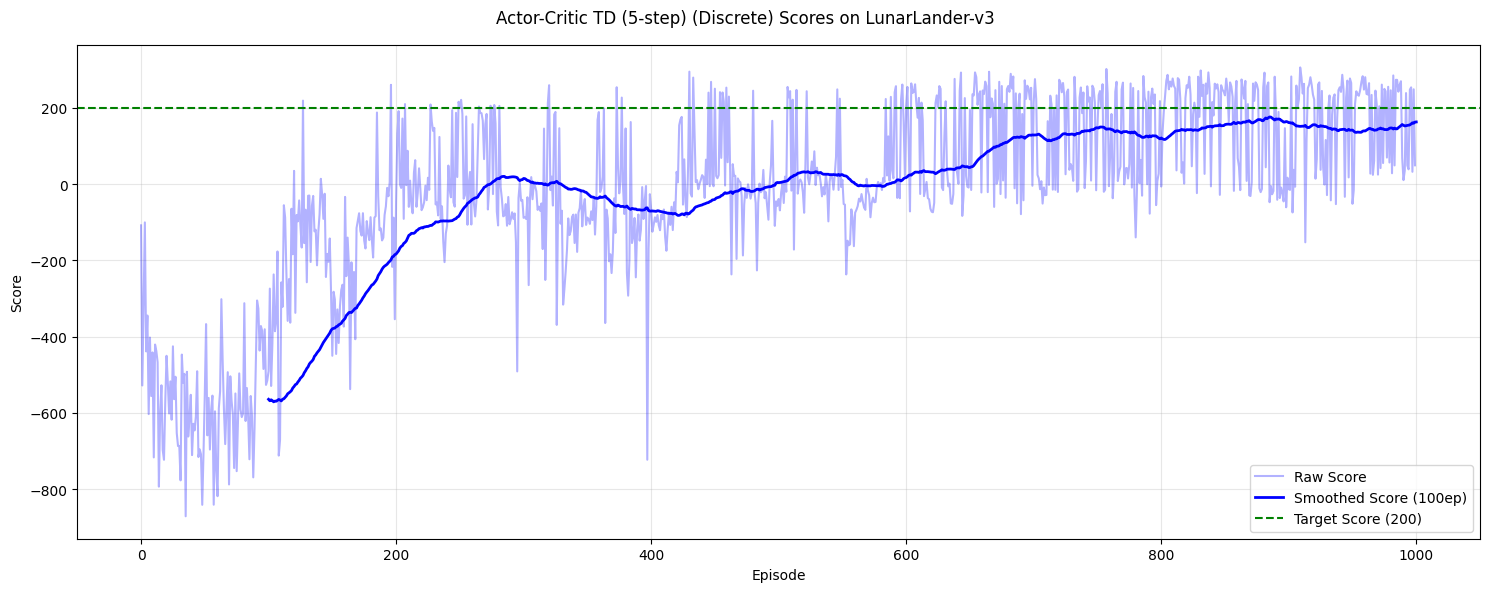

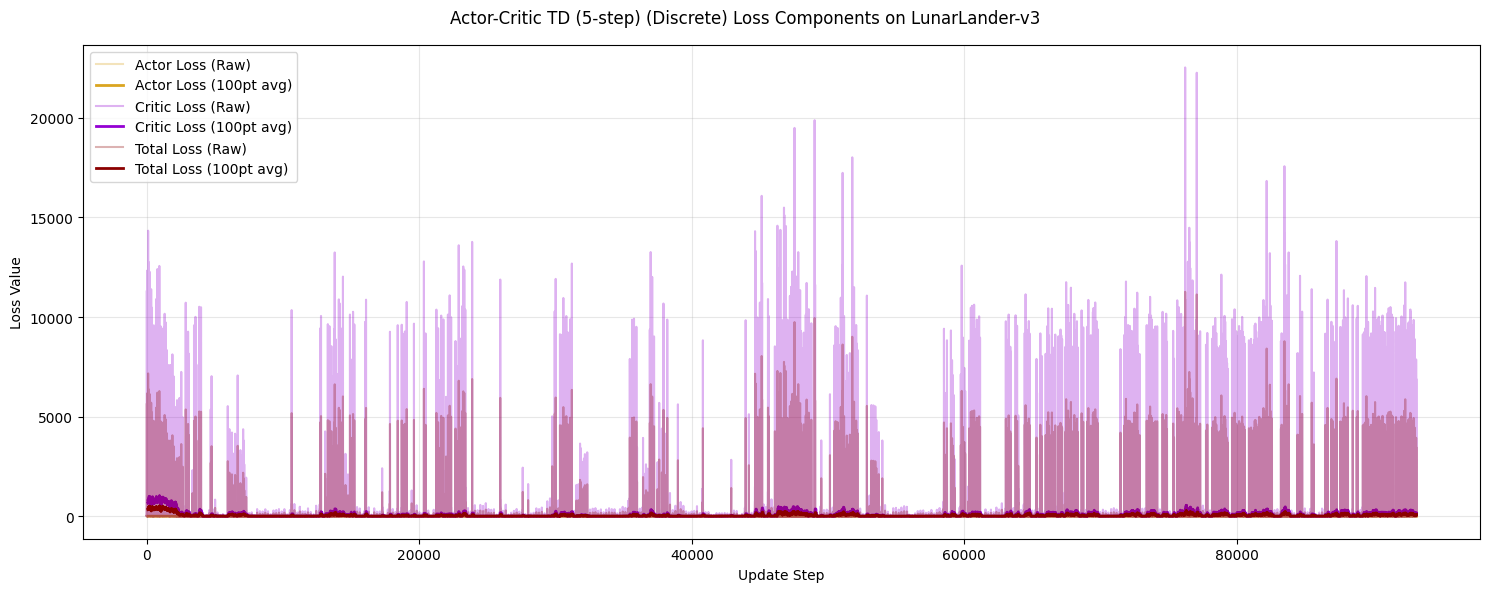

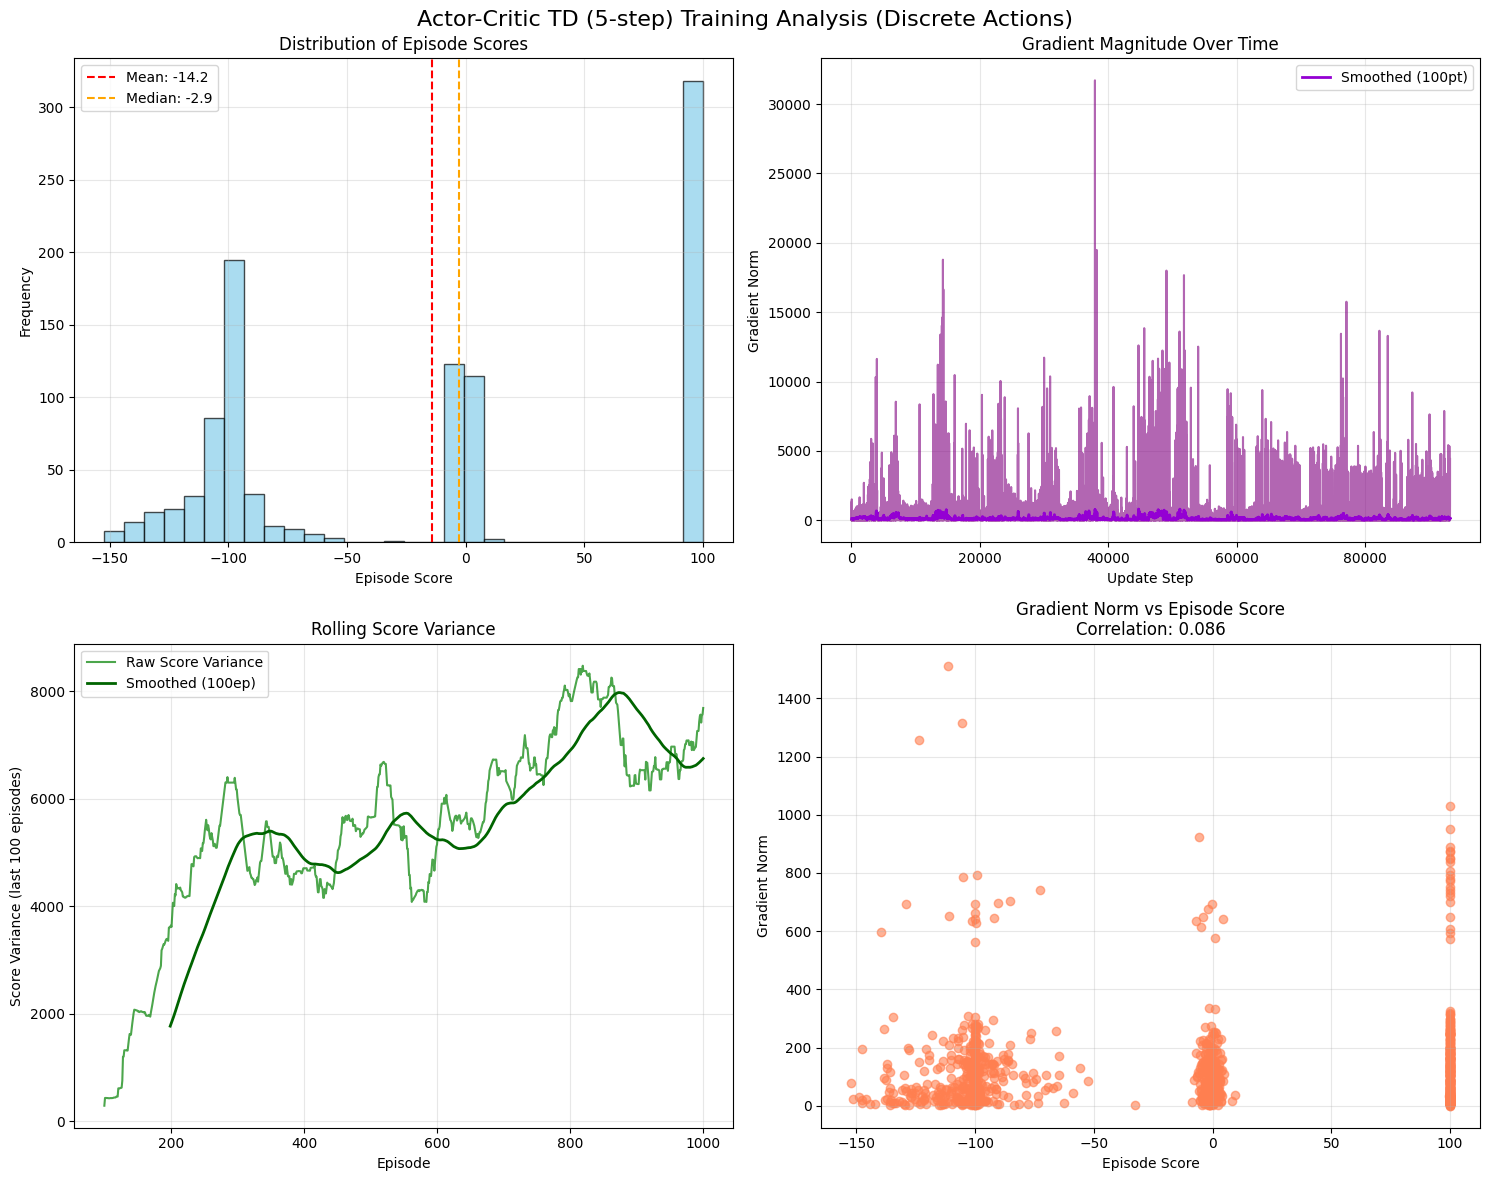

In [5]:
# Plot results for discrete TD learning
plot_training_results(
    discrete_td_scores, 
    discrete_td_agent.loss_history, 
    CONFIG, 
    "Discrete", 
    algorithm_name=f"Actor-Critic TD ({CONFIG['n_steps']}-step)"
)

# Show variance analysis
plot_variance_analysis(
    discrete_td_agent, 
    discrete_td_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name=f"Actor-Critic TD ({CONFIG['n_steps']}-step)"
)
# Show advantage normalization statistics
adv_stats = discrete_td_agent.get_advantage_normalization_stats()

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_td_scores))
final_avg = np.mean(discrete_td_scores[-final_window_size:]) if final_window_size > 0 else 0.0


In [6]:
# --- CONTINUOUS ACTION SPACE: TD LEARNING ---
print("Starting Actor-Critic TD training with CONTINUOUS actions...")

continuous_td_scores, continuous_td_losses, continuous_td_agent = train_actor_critic_td(
    is_continuous=True, 
    config=CONFIG
)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


Ep  999 | Score:   89.9 | AvgScore(100):  -46.3 | Updates: 95578 | ActorLoss:  0.2130 | CriticLoss: 6926.6445 | GradNorm: 4431.2426 | GradClip%: 100.0 | AdvFail:  0.2%: 100%|█████████▉| 999/1000 [42:45<00:06,  6.83s/episode]

📹 9 training videos available in videos/ActorCritic_TD_continuous


Ep 1000 | Score:  172.5 | AvgScore(100):  -43.6 | Updates: 95730 | ActorLoss: -1.2291 | CriticLoss: 8961.9229 | GradNorm: 2479.5946 | GradClip%: 100.0 | AdvFail:  0.2%: 100%|██████████| 1000/1000 [42:50<00:00,  2.57s/episode]


Continuous training completed in 2570.6 seconds!


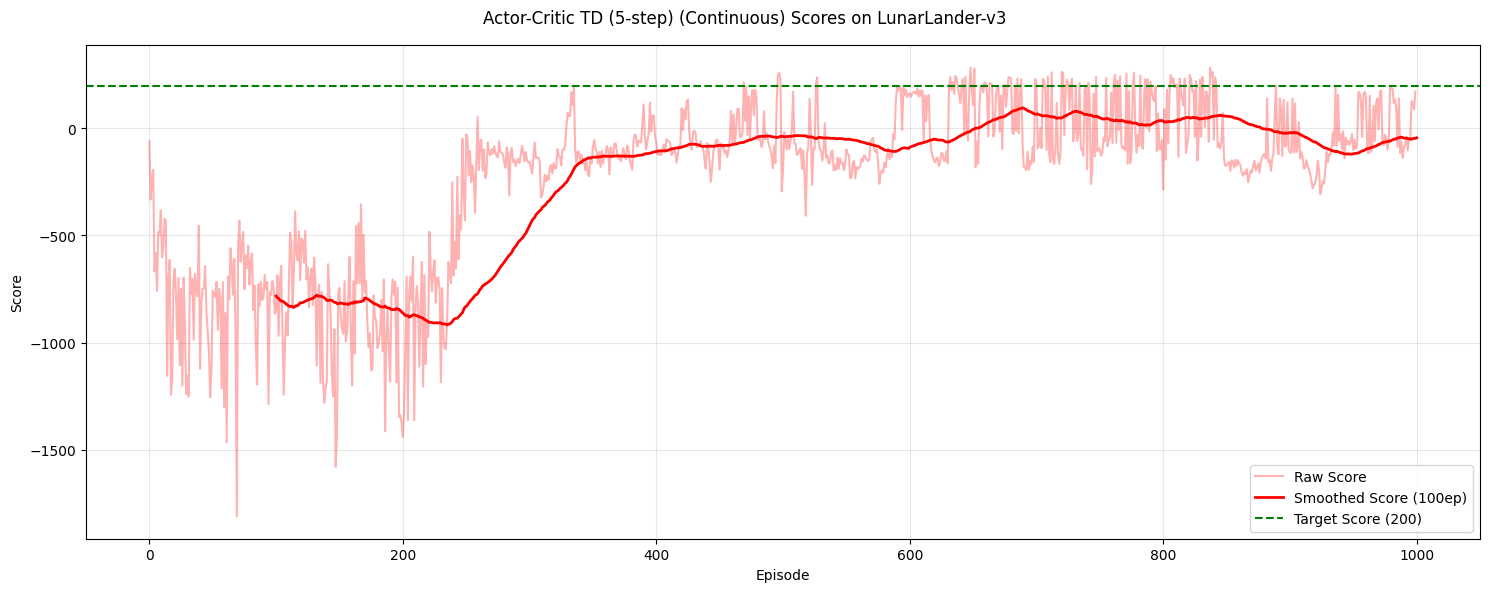

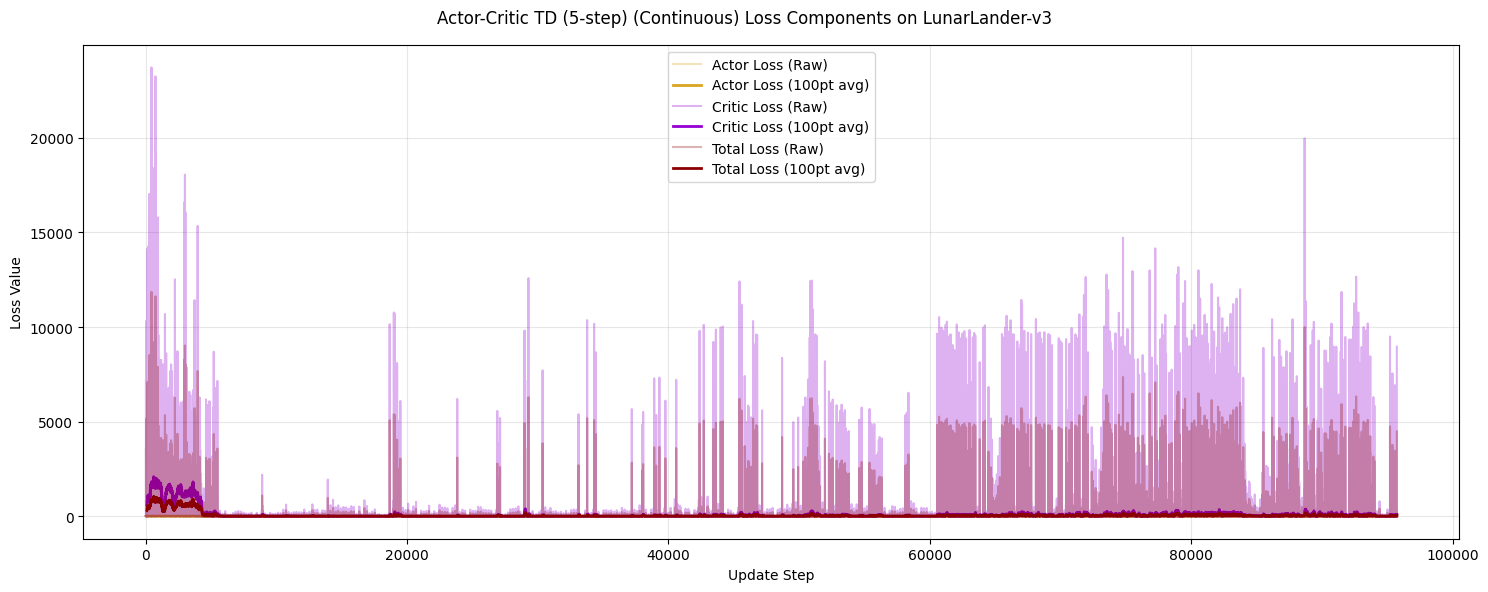

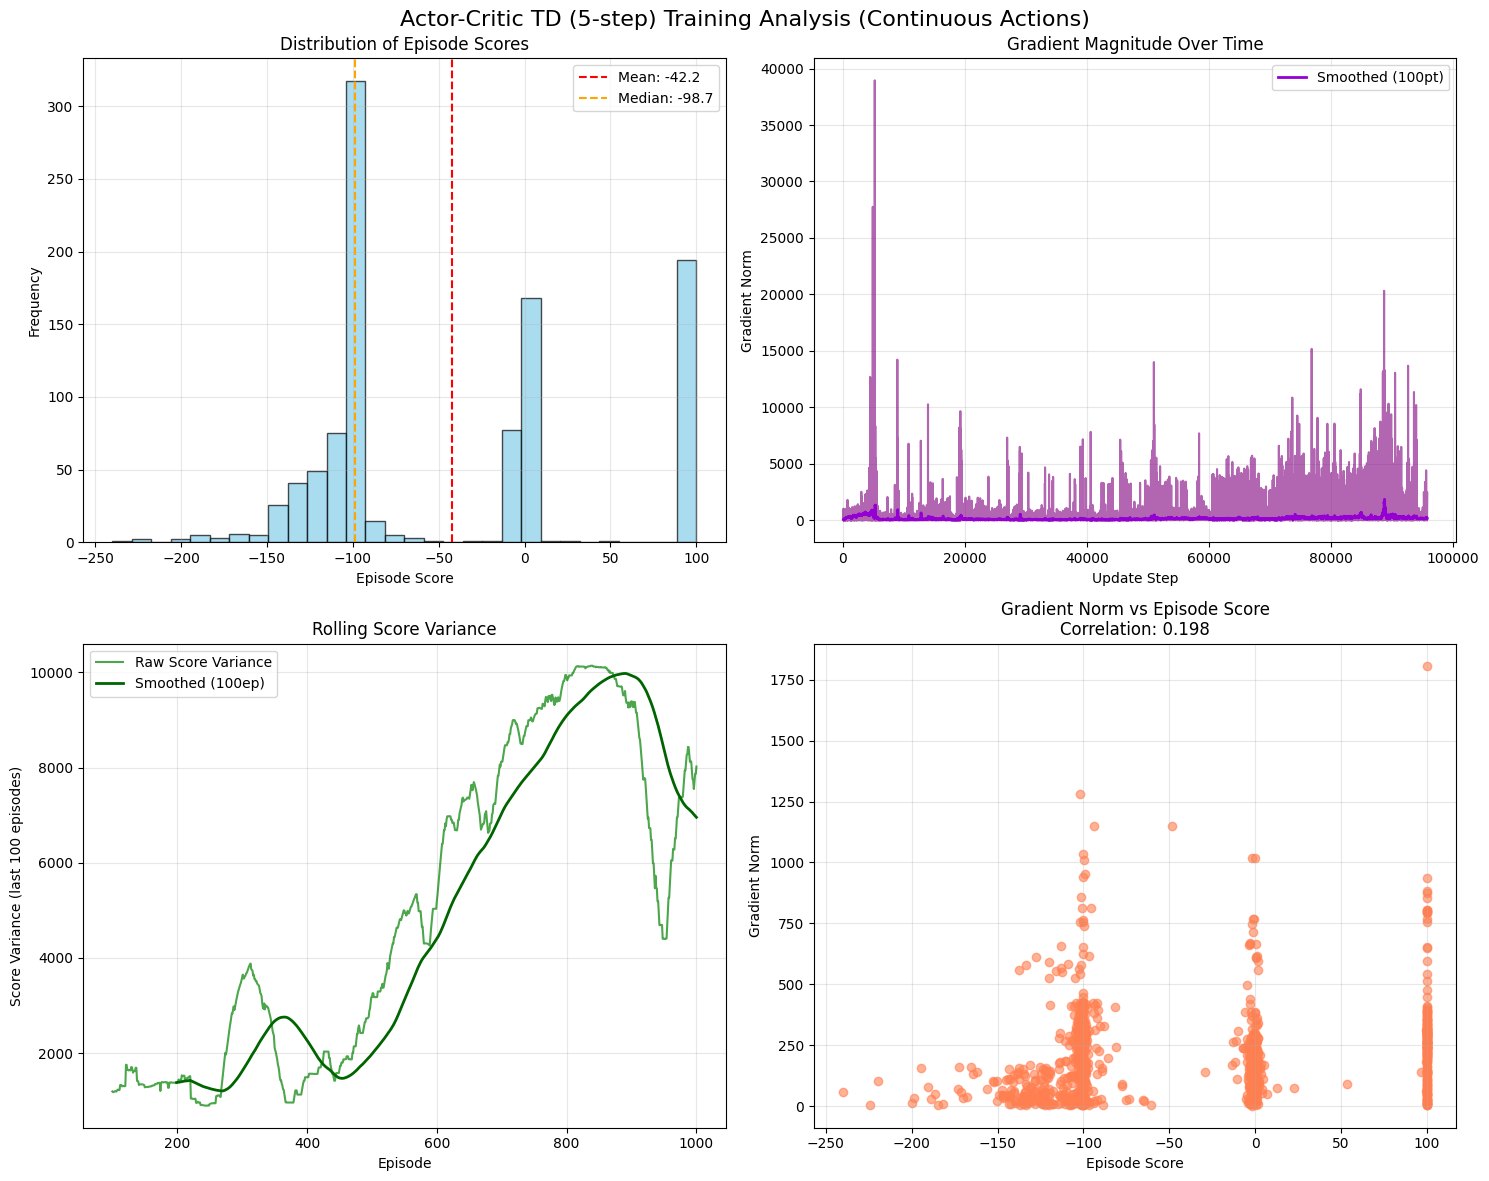

In [7]:
# Plot results for continuous TD learning
plot_training_results(
    continuous_td_scores, 
    continuous_td_agent.loss_history, 
    CONFIG, 
    "Continuous", 
    algorithm_name=f"Actor-Critic TD ({CONFIG['n_steps']}-step)"
)

# Show variance analysis
plot_variance_analysis(
    continuous_td_agent, 
    continuous_td_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name=f"Actor-Critic TD ({CONFIG['n_steps']}-step)"
)

# Show advantage normalization statistics
adv_stats = continuous_td_agent.get_advantage_normalization_stats()

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_td_scores))
final_avg = np.mean(continuous_td_scores[-final_window_size:]) if final_window_size > 0 else 0.0



COMPREHENSIVE ANALYSIS: Actor-Critic TD Performance

📊 FINAL PERFORMANCE COMPARISON (last 100 episodes):
Method               Final Score  Score Std  Grad Std   Updates  Up/Ep    AdvFail%   GradClip%   Grad CV  Score CV  Parameters  
--------------------------------------------------------------------------------------------------------------------------------------------
Discrete TD          163.0        87.7       534.4400   93184    93.2     0.2        100.0       3.697    2.390     9,445       
Continuous TD        -43.6        89.6       265.6653   95730    95.7     0.2        100.0       1.744    -2.413    9,381       

📈 TD-SPECIFIC ANALYSIS:
Discrete TD:
  Score variance (last 100 episodes): 7684.9
Continuous TD:
  Score variance (last 100 episodes): 8022.9


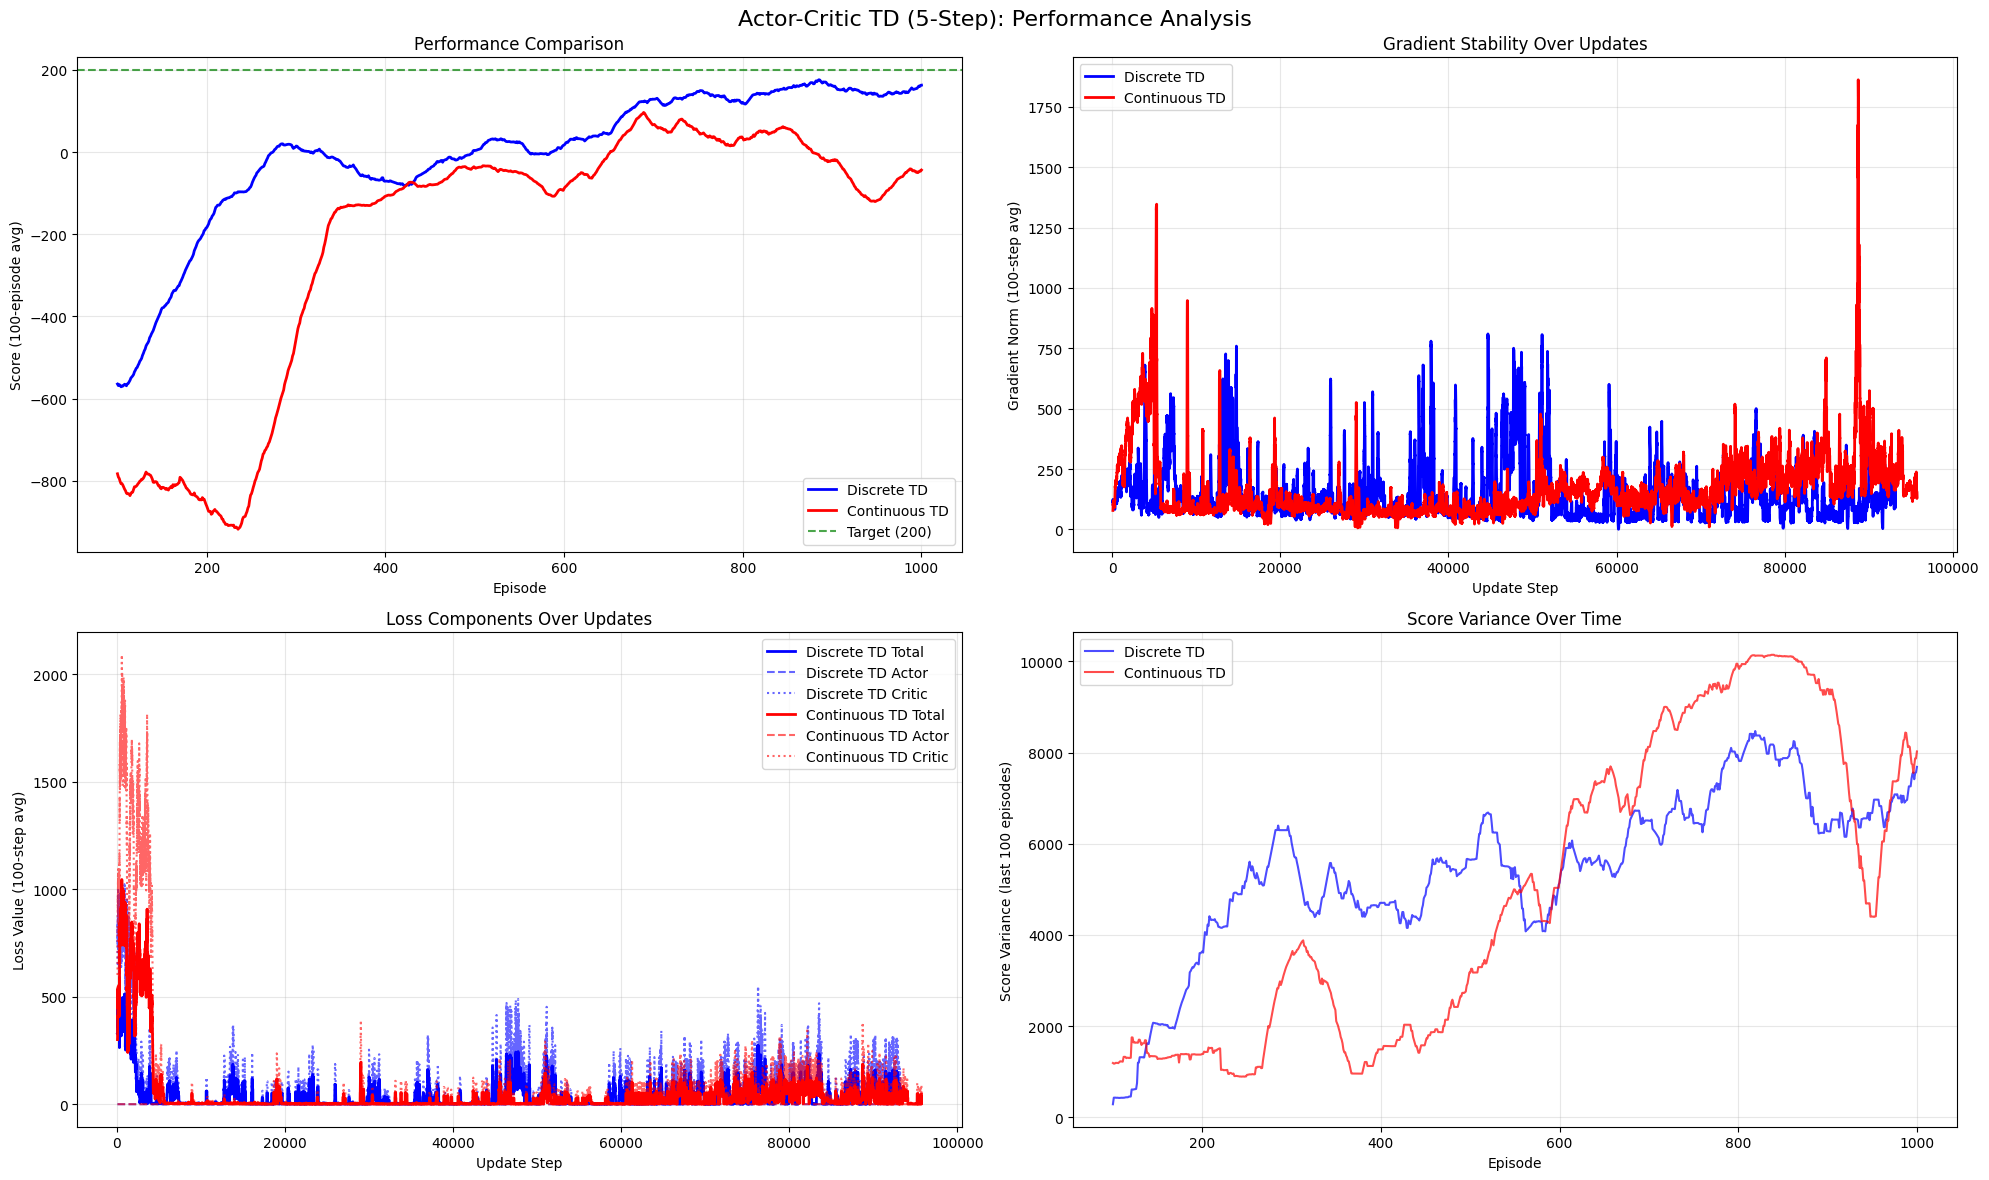

In [8]:
# --- COMPREHENSIVE ANALYSIS: Actor-Critic TD Performance ---
import matplotlib.pyplot as plt
from rl_utils.visualization import get_moving_average

print(f"\n{'='*80}")
print(f"COMPREHENSIVE ANALYSIS: Actor-Critic TD Performance")
print(f"{'='*80}")

# Collect experiment results
experiments = [
    ("Discrete TD", discrete_td_scores, discrete_td_agent),
    ("Continuous TD", continuous_td_scores, continuous_td_agent),
]

print(f"\n📊 FINAL PERFORMANCE COMPARISON (last {CONFIG['window_length']} episodes):")
print(f"{'Method':<20} {'Final Score':<12} {'Score Std':<10} {'Grad Std':<10} {'Updates':<8} {'Up/Ep':<8} {'AdvFail%':<10} {'GradClip%':<11} {'Grad CV':<8} {'Score CV':<9} {'Parameters':<12}")
print("-" * 140)

for name, scores, agent in experiments:
    final_window_size = min(CONFIG["window_length"], len(scores))
    final_score = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    
    stats = agent.get_variance_stats()
    total_updates = getattr(agent, 'update_step', 0)
    updates_per_episode = total_updates / CONFIG["episodes"] if CONFIG["episodes"] > 0 else 0.0
    adv_stats = agent.get_advantage_normalization_stats()
    failure_rate = adv_stats.get("fallback_rate_percent", 0.0)
    grad_clip_stats = agent.get_gradient_clip_stats()
    grad_clip_rate = grad_clip_stats.get("windowed_clip_rate_percent", 0.0)
    param_count = agent.network.get_param_count()
    
    print(f"{name:<20} {final_score:<12.1f} {stats['score_std']:<10.1f} {stats['gradient_norm_std']:<10.4f} {total_updates:<8} {updates_per_episode:<8.1f} {failure_rate:<10.1f} {grad_clip_rate:<11.1f} {stats['gradient_cv']:<8.3f} {stats['score_cv']:<9.3f} {param_count:<12,}")

print(f"\n📈 TD-SPECIFIC ANALYSIS:")
for name, scores, agent in experiments:
    stats = agent.get_variance_stats()
    recent_score_var = stats.get('recent_score_variance', 0.0)
    adv_stats = agent.get_advantage_normalization_stats()
    grad_clip_stats = agent.get_gradient_clip_stats()
    
    print(f"{name}:")
    print(f"  Score variance (last {CONFIG['window_length']} episodes): {recent_score_var:.1f}")
    # print(f"  Advantage norm fallbacks: {adv_stats['fallback_normalizations']} of {adv_stats['total_actor_updates']} ({adv_stats['fallback_rate_percent']:.1f}%)")
    # print(f"  N-step parameter: {CONFIG['n_steps']} steps")

# Create TD-specific analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle(f'Actor-Critic TD ({CONFIG["n_steps"]}-Step): Performance Analysis', fontsize=16)

colors = ['blue', 'red']
smoothing_window = CONFIG["window_length"]

# 1. Performance comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(scores) >= smoothing_window:
        smoothed, offset = get_moving_average(scores, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax1.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2)

ax1.axhline(y=CONFIG["target_score"], color='g', linestyle='--', label=f'Target ({CONFIG["target_score"]})', alpha=0.7)
ax1.set_xlabel('Episode')
ax1.set_ylabel(f'Score ({smoothing_window}-episode avg)')
ax1.set_title('Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Update frequency (gradient norms over update steps, not episodes)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.gradient_norms) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.gradient_norms, window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax2.plot(update_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax2.set_xlabel('Update Step')
ax2.set_ylabel(f'Gradient Norm ({smoothing_window}-step avg)')
ax2.set_title('Gradient Stability Over Updates')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss components over update steps
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.loss_history["total_loss"]) >= smoothing_window:
        # Plot total loss
        smoothed_total, offset = get_moving_average(agent.loss_history["total_loss"], window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed_total))
        ax3.plot(update_steps, smoothed_total, label=f'{name} Total', color=colors[i], linewidth=2)
        
        # Plot actor and critic losses with transparency
        if len(agent.loss_history["actor_loss"]) >= smoothing_window:
            smoothed_actor, _ = get_moving_average(agent.loss_history["actor_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_actor, label=f'{name} Actor', color=colors[i], alpha=0.6, linestyle='--')
        
        if len(agent.loss_history["critic_loss"]) >= smoothing_window:
            smoothed_critic, _ = get_moving_average(agent.loss_history["critic_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_critic, label=f'{name} Critic', color=colors[i], alpha=0.6, linestyle=':')

ax3.set_xlabel('Update Step')
ax3.set_ylabel(f'Loss Value ({smoothing_window}-step avg)')
ax3.set_title('Loss Components Over Updates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Score variance over time
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.score_variance_history) > 0:
        variance_start = CONFIG["window_length"]
        variance_episodes = range(variance_start, variance_start + len(agent.score_variance_history))
        ax4.plot(variance_episodes, agent.score_variance_history, label=name, color=colors[i], alpha=0.7)

ax4.set_xlabel('Episode')
ax4.set_ylabel(f'Score Variance (last {CONFIG["window_length"]} episodes)')
ax4.set_title('Score Variance Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Learning Outcomes and Analysis

### 🔍 Understanding RL Losses vs Performance

TD learning adds **bootstrapping complexity** that makes losses even less reliable as performance indicators:

**Actor Loss**: `-(log_probs * normalized_advantages).mean()`
- Uses advantages from TD estimates, not true returns
- High loss often coincides with rapid policy improvement

**Critic Loss**: `mse_loss(values, td_targets)` 
- **Bootstrapping paradox**: We train the network to match its own (potentially wrong) predictions
- Low critic loss can mean the network is consistent with itself, not necessarily accurate
- **Moving target problem**: As the value function improves, TD targets change, creating non-stationary learning

**TD-Specific Issue**: The **100x update frequency** (93 updates/episode vs 1 for MC) means loss values fluctuate wildly as the network constantly adapts to its own changing predictions.

**Focus instead on**: Episode scores, gradient stability, and advantage normalization fallback rates as health indicators.

### 🎯 Performance Summary

Actor-Critic TD shows the dramatic impact of bootstrapping and frequent updates:

**Discrete TD**: Final Score = 163.0 🟢 (The first time we had score > 100)  
**Continuous TD**: Final Score = -43.6 ❌ (Failed to learn)

### 📊 Learning Dynamics Revolution

The most striking difference from previous methods is the **update frequency**:

**Previous Methods (REINFORCE, AC-MC)**: 1 update per episode (1,000 total updates)
**Actor-Critic TD**: 
- Discrete: 93,184 updates (93.2 updates per episode)
- Continuous: 95,730 updates (95.7 updates per episode)

**Result**: Nearly 100x more learning opportunities through N-step bootstrapping.

### 🎯 Gradient Stability Analysis

**Discrete TD**: Gradient CV = 3.697 🔴 (Poor stability)  
**Continuous TD**: Gradient CV = 1.744 🔴 (Poor stability)

**Trade-off Revealed**: TD learning introduces significant gradient instability despite better performance. The frequent updates and bootstrapping create feedback loops that increase gradient variance.

### 📈 Score Stability Analysis  

**Discrete TD**: Score CV = 2.390 🔴 (Very unstable performance)  
**Continuous TD**: Score CV = -2.413 🔴 (Very unstable performance)

Even the successful discrete TD agent shows high performance variance, indicating that while it learned to succeed, the learning is not yet robust.

### 🔍 TD-Specific Insights

1. **Bootstrapping Success**: The discrete agent's success validates the TD learning approach
2. **Action Space Sensitivity**: TD learning appears much more sensitive to action space choice than previous methods
3. **Advantage Normalization Robustness**: Very low fallback rate (0.2%) shows N-step updates provide sufficient data for stable normalization
4. **Bias-Variance Tradeoff**: Trading Monte Carlo's high variance for TD's bias pays off in discrete case

### ⚠️ Stability Concerns

The high gradient and score CVs reveal TD learning's fundamental challenge:
- **Feedback Loops**: Using estimates to update estimates creates instability
- **Hyperparameter Sensitivity**: Success depends heavily on careful tuning
- **Environment Dependence**: Discrete vs continuous results suggest method sensitivity

### 🚀 Motivation for A2C

TD learning's instability despite performance gains sets up the motivation for A2C:
- **Need for parallel environments** to stabilize gradients
- **Batch updates** to reduce variance
- **Synchronized learning** for consistent progress

The next step is addressing TD's instability while preserving its sample efficiency benefits.